<a href="https://colab.research.google.com/github/hn-iiitd/CGAS-Recipe-Review-Sentiment-Analysis/blob/main/RecipeReviewSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Independent Project

Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

# # Download latest version
path = kagglehub.dataset_download("shuyangli94/food-com-recipes-and-user-interactions")
# path = "Recipes-Review-main.zip"
print("Path to dataset files:", path)

100%|██████████| 267M/267M [00:08<00:00, 31.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shuyangli94/food-com-recipes-and-user-interactions/versions/2


EDA

In [ ]:
df1 = pd.read_csv(path+"/RAW_interactions.csv")

df1.shape

(1132367, 5)

In [ ]:

# Data cleaning

df1 = df1[df1['review'].astype(str).str.strip() != ''] # Dropping empty reviews
df1 = df1.dropna(subset=['review']) # Dropping NaN reviews
df1 = df1[df1['rating'] != 0] # Rating should be Non zero


print(df1.shape)

(1071348, 5)


In [ ]:
df1.head()
df1.drop(columns = ["user_id","recipe_id","date"])

,rating,review
0,4,Great with a salad. Cooked on top of stove for...
1,5,"So simple, so delicious! Great for chilly fall..."
2,4,This worked very well and is EASY. I used not...
3,5,I made the Mexican topping and took it to bunk...
4,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...
1132360,5,Delicious quick thick chocolate sauce with ing...
1132363,5,These were so delicious! My husband and I tru...
1132364,5,WOW! Sometimes I don't take the time to rate ...
1132365,4,Very good! I used regular port as well. The ...


In [ ]:
df1 = df1.drop(columns = ["user_id","recipe_id","date"])

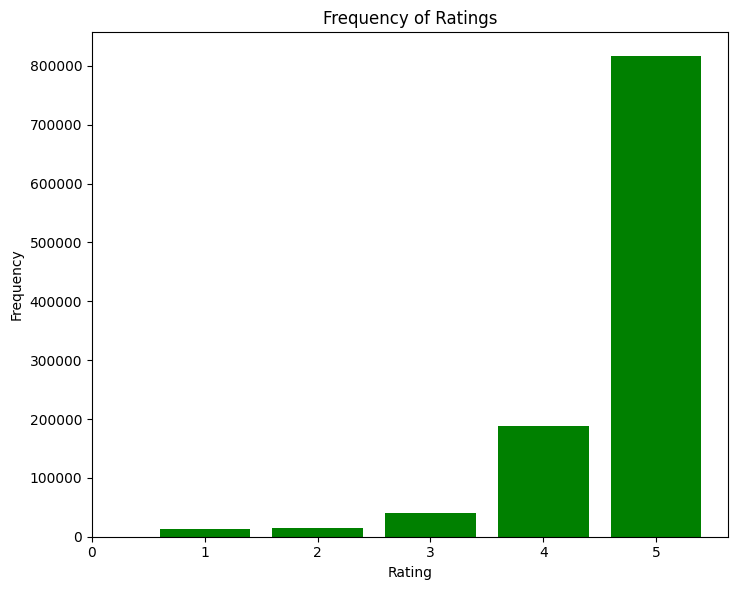

In [ ]:
orig_counts = df1['rating'].value_counts()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.bar(orig_counts.index, orig_counts.values, color='green')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings")
plt.xticks(range(0, 6))

plt.tight_layout()
plt.show()

In [ ]:
df2 = df1.copy()


In [ ]:
df1.loc[df1['rating'].isin([1, 2]), 'rating'] = 0
df1.loc[df1['rating'] == 3, 'rating'] = 1
df1.loc[df1['rating'].isin([4, 5]), 'rating'] = 2

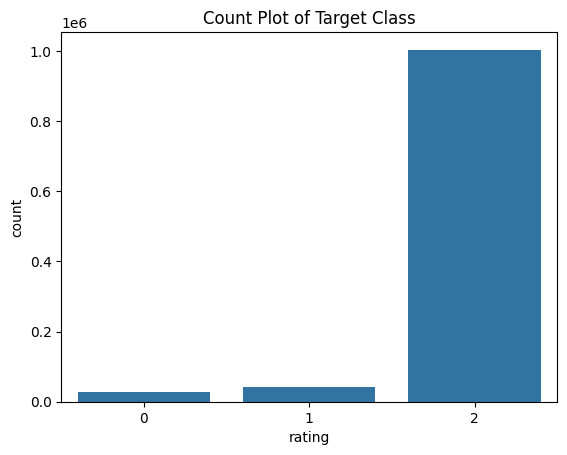

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=df1["rating"])  # 'x=' is required in newer versions of seaborn
plt.title("Count Plot of Target Class")
plt.show()


In [ ]:
import pandas as pd

# Count the number of samples in each class
min_class_count = df1['rating'].value_counts().min()

# Sample an equal number of instances for each class
df1 = df1.groupby('rating').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)


<ipython-input-11-40303bfd4fdb>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df1.groupby('rating').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)


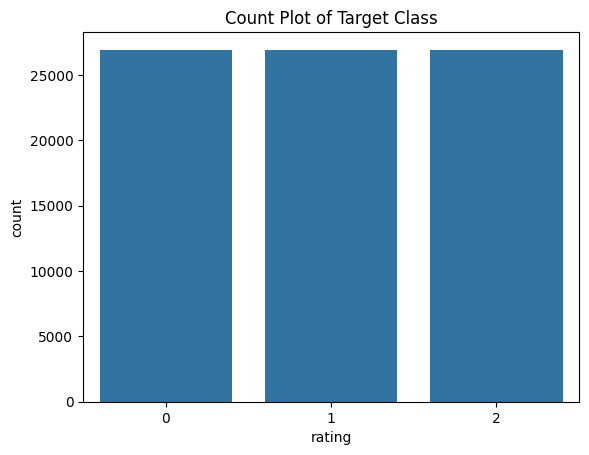

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=df1["rating"])  # 'x=' is required in newer versions of seaborn
plt.title("Count Plot of Target Class")
plt.show()


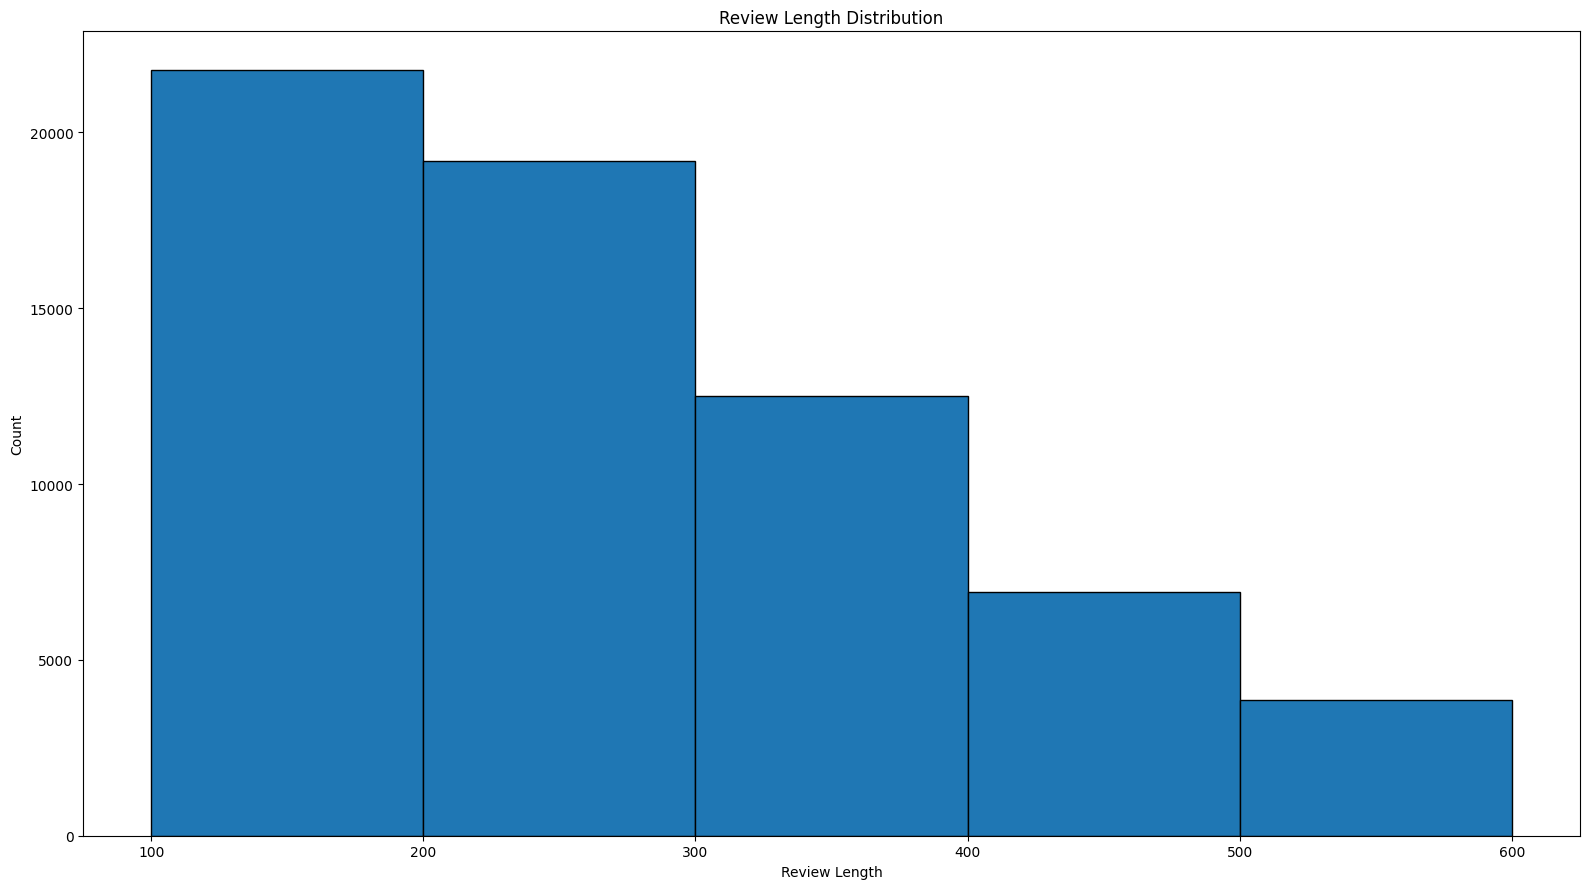

In [ ]:
a = df1["review"].apply(lambda x: len(x))
plt.figure(figsize = (16, 9))
bins_ = [100, 200, 300, 400, 500, 600]
plt.hist(a, bins = bins_, edgecolor = 'black')

plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Assuming df is already loaded with a 'review' column

# Tokenize each review by splitting on whitespace and converting to lowercase
words = df1['review'].apply(lambda x: x.split()).explode().str.lower()

# Get unique words
unique_words = words.unique()

# Print unique words
print("Unique words in the reviews:", unique_words)
print(f"Number of unique words: {len(unique_words)}")


Unique words in the reviews: ['this' 'definitely' 'has' ... 'soymilk).' 'w/raisins.' 'nutty/raisins']
Number of unique words: 104946


In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

def generate_review_wordcloud(df, review_column='review', max_reviews=500):
    # Get reviews and limit to max_reviews if specified
    reviews = df[review_column].head(max_reviews)

    # Initialize stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('made')
    stop_words.add('would')
    stop_words.add('make')
    stop_words.add('recipe')
    # Process reviews
    comment_words = []
    for review in reviews:
        # Convert to string and lowercase
        review = str(review).lower()

        # Split into words and filter out stopwords
        words = [word for word in review.split() if word not in stop_words]

        # Add to comment words
        comment_words.extend(words)

    # Join all words
    text = ' '.join(comment_words)

    # Create WordCloud object
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color='white',
        stopwords=stop_words,
        min_font_size=10
    ).generate(text)

    # Create the plot
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    return plt

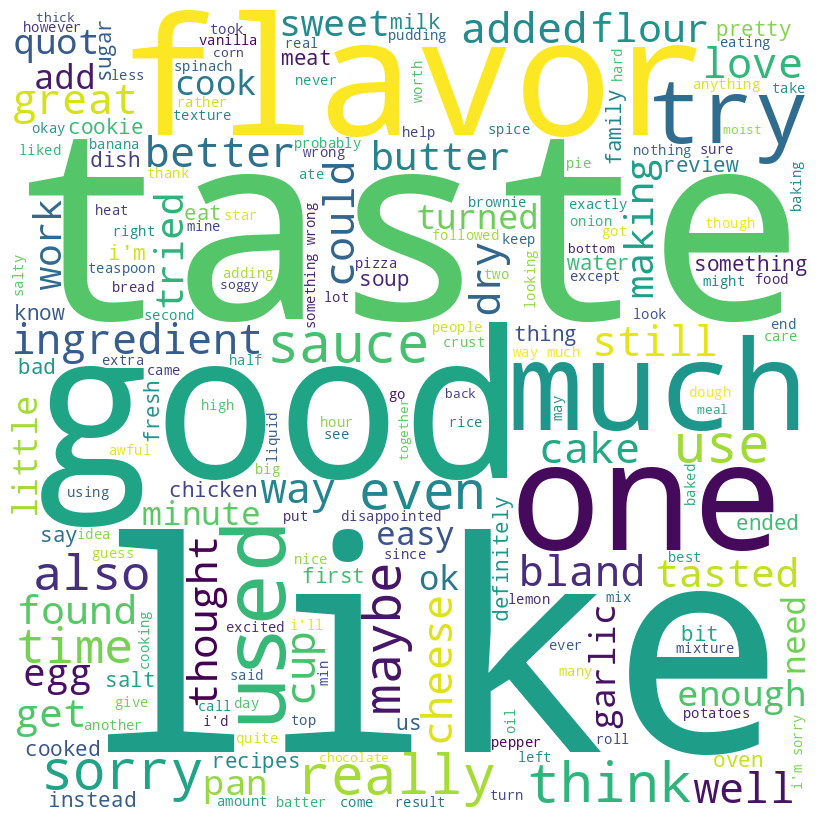

In [ ]:
wordcloud_plot = generate_review_wordcloud(df1)
wordcloud_plot.show()

Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt_tab')

# Initialize stopwords once
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags (simplified version)
    text = re.sub(r'<[^>]+>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    return words

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
sample_text = "Hello! This is some sample text with HTML <tags> and numbers 123."
processed_words = preprocess_text(sample_text)
print(processed_words)

['hello', 'sample', 'text', 'html', 'numbers']


In [ ]:
data = df1.copy()
texts = data['review'].tolist()
processed_texts = [preprocess_text(text) for text in texts]

Word2vec

In [ ]:
from gensim.models import KeyedVectors
model_path = "word2vec.model"

model = Word2Vec.load(model_path)


In [ ]:
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from typing import List, Union
import logging

def get_sentence_vector(sentence: List[str],
                       model: Union[Word2Vec, KeyedVectors],
                       vector_size: int) -> np.ndarray:
    try:
        # Handle both Word2Vec and KeyedVectors models
        word_vectors = model.wv if hasattr(model, 'wv') else model

        # Get vectors for valid words only
        valid_words = [word for word in sentence if word in word_vectors]

        if not valid_words:
            logging.warning(f"No valid words found in sentence: {' '.join(sentence)}")
            return np.zeros(vector_size)

        # Calculate average vector
        vectors = [word_vectors[word] for word in valid_words]
        return np.mean(vectors, axis=0)

    except Exception as e:
        logging.error(f"Error processing sentence: {e}")
        return np.zeros(vector_size)

def generate_sentence_embeddings(texts: List[List[str]],
                               model_path: str,
                               vector_size: int) -> np.ndarray:

    try:
        # Load the model
        try:
            model = Word2Vec.load(model_path)
        except:
            model = KeyedVectors.load(model_path)

        # Generate vectors for all sentences
        sentence_vectors = np.array([
            get_sentence_vector(sentence, model, vector_size)
            for sentence in texts
        ])

        logging.info(f"Generated vectors with shape: {sentence_vectors.shape}")
        return sentence_vectors

    except Exception as e:
        logging.error(f"Error generating sentence embeddings: {e}")
        raise





In [ ]:
vector_size = 200
model_path = "word2vec.model"
sentence_vectors = generate_sentence_embeddings(processed_texts, model_path, vector_size)
print(f"Generated vectors shape: {sentence_vectors.shape}")

Generated vectors shape: (80811, 200)


In [ ]:
X_orig = sentence_vectors
y_orig = data['rating']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42,stratify=y_orig)

Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import pickle


lr_model = LogisticRegression(max_iter=3000)
lr_model.fit(X_train_orig, y_train_orig)

with open("LR_model","wb") as fd:
  pickle.dump(lr_model,fd)

# Making predictions
y_pred = lr_model.predict(X_test_orig)

# Evaluating the model
lr_accuracy = accuracy_score(y_test_orig, y_pred)
lr_precision = precision_score(y_test_orig, y_pred, average='weighted')
lr_recall = recall_score(y_test_orig, y_pred, average='weighted')
lr_f1 = f1_score(y_test_orig, y_pred, average='weighted')

print(f'Accuracy: {lr_accuracy:.4f}')
print(f'Precision: {lr_precision:.4f}')
print(f'Recall: {lr_recall:.4f}')
print(f'F1 Score: {lr_f1:.4f}')
print('Classification Report:')
print(classification_report(y_test_orig, y_pred))

# Checking for overfitting
y_train_pred = lr_model.predict(X_train_orig)
train_accuracy = accuracy_score(y_train_orig, y_train_pred)
test_accuracy = accuracy_score(y_test_orig, y_pred)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Testing Accuracy: {test_accuracy:.4f}')


Accuracy: 0.7285
Precision: 0.7267
Recall: 0.7285
F1 Score: 0.7275
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      5387
           1       0.64      0.62      0.63      5388
           2       0.81      0.84      0.83      5388

    accuracy                           0.73     16163
   macro avg       0.73      0.73      0.73     16163
weighted avg       0.73      0.73      0.73     16163

Training Accuracy: 0.7285
Testing Accuracy: 0.7285


Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

rf_model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf_model.fit(X_train_orig, y_train_orig)


with open("RF_model","wb") as fd:
  pickle.dump(rf_model,fd)

# Making predictions
y_pred = rf_model.predict(X_test_orig)
y_train_pred = rf_model.predict(X_train_orig)

# Evaluating the model
rf_accuracy = accuracy_score(y_test_orig, y_pred)
rf_precision = precision_score(y_test_orig, y_pred, average='weighted')
rf_recall = recall_score(y_test_orig, y_pred, average='weighted')
rf_f1 = f1_score(y_test_orig, y_pred, average='weighted')

print(f'Accuracy: {rf_accuracy:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')
print(f'F1 Score: {rf_f1:.4f}')
print('Classification Report:')
print(classification_report(y_test_orig, y_pred))
train_accuracy = accuracy_score(y_train_orig, y_train_pred)

print(f'Training Accuracy: {train_accuracy:.4f}')


Accuracy: 0.6777
Precision: 0.6717
Recall: 0.6777
F1 Score: 0.6731
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      5387
           1       0.59      0.51      0.55      5388
           2       0.75      0.81      0.78      5388

    accuracy                           0.68     16163
   macro avg       0.67      0.68      0.67     16163
weighted avg       0.67      0.68      0.67     16163

Training Accuracy: 0.7151


XGBoost and LGBM

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_orig, y_train_orig)


with open("XGB_model","wb") as fd:
  pickle.dump(xgb_model,fd)

lgbm_model = LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train_orig, y_train_orig)


with open("LGBM_model","wb") as fd:
  pickle.dump(lgbm_model,fd)

# Making predictions
y_pred_xgb = xgb_model.predict(X_test_orig)
y_pred_lgbm = lgbm_model.predict(X_test_orig)

y_train_pred_xgb = xgb_model.predict(X_train_orig)
y_train_pred_lgbm = lgbm_model.predict(X_train_orig)

# Evaluating XGBoost model
accuracy_xgb = accuracy_score(y_test_orig, y_pred_xgb)
precision_xgb = precision_score(y_test_orig, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_orig, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_orig, y_pred_xgb, average='weighted')

print('XGBoost Model:')
print(f'Accuracy: {accuracy_xgb:.4f}')
print(f'Precision: {precision_xgb:.4f}')
print(f'Recall: {recall_xgb:.4f}')
print(f'F1 Score: {f1_xgb:.4f}')
print('Classification Report:')
print(classification_report(y_test_orig, y_pred_xgb))

# Checking for overfitting in XGBoost
train_accuracy_xgb = accuracy_score(y_train_orig, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test_orig, y_pred_xgb)
print(f'Training Accuracy: {train_accuracy_xgb:.4f}')
print(f'Testing Accuracy: {test_accuracy_xgb:.4f}')


# Evaluating LightGBM model
accuracy_lgbm = accuracy_score(y_test_orig, y_pred_lgbm)
precision_lgbm = precision_score(y_test_orig, y_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test_orig, y_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test_orig, y_pred_lgbm, average='weighted')

print('\nLightGBM Model:')
print(f'Accuracy: {accuracy_lgbm:.4f}')
print(f'Precision: {precision_lgbm:.4f}')
print(f'Recall: {recall_lgbm:.4f}')
print(f'F1 Score: {f1_lgbm:.4f}')
print('Classification Report:')
print(classification_report(y_test_orig, y_pred_lgbm))

# Checking for overfitting in LightGBM
train_accuracy_lgbm = accuracy_score(y_train_orig, y_train_pred_lgbm)
test_accuracy_lgbm = accuracy_score(y_test_orig, y_pred_lgbm)
print(f'Training Accuracy: {train_accuracy_lgbm:.4f}')
print(f'Testing Accuracy: {test_accuracy_lgbm:.4f}')


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:48:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 64648, number of used features: 200
[LightGBM] [Info] Start training from score -1.098581
[LightGBM] [Info] Start training from score -1.098628
[LightGBM] [Info] Start training from score -1.098628


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


XGBoost Model:
Accuracy: 0.7207
Precision: 0.7184
Recall: 0.7207
F1 Score: 0.7193
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      5387
           1       0.63      0.60      0.61      5388
           2       0.82      0.84      0.83      5388

    accuracy                           0.72     16163
   macro avg       0.72      0.72      0.72     16163
weighted avg       0.72      0.72      0.72     16163

Training Accuracy: 0.9980
Testing Accuracy: 0.7207

LightGBM Model:
Accuracy: 0.7272
Precision: 0.7251
Recall: 0.7272
F1 Score: 0.7260
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      5387
           1       0.63      0.60      0.62      5388
           2       0.82      0.84      0.83      5388

    accuracy                           0.73     16163
   macro avg       0.73      0.73      0.73     16163
weighted avg       0.73      0

Support Vector Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score


# Initializing and training the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovr', random_state=42)
svm_model.fit(X_train_orig, y_train_orig)


with open("SVM_model","wb") as fd:
  pickle.dump(svm_model,fd)

y_pred = svm_model.predict(X_test_orig)
y_train_pred = svm_model.predict(X_train_orig)

svm_accuracy = accuracy_score(y_test_orig, y_pred)
svm_precision = precision_score(y_test_orig, y_pred, average='weighted')
svm_recall = recall_score(y_test_orig, y_pred, average='weighted')
svm_f1 = f1_score(y_test_orig, y_pred, average='weighted')

print(f'Accuracy: {svm_accuracy:.4f}')
print(f'Precision: {svm_precision:.4f}')
print(f'Recall: {svm_recall:.4f}')
print(f'F1 Score: {svm_f1:.4f}')
print('Classification Report:')
print(classification_report(y_test_orig, y_pred))

# Checking for overfitting
train_accuracy = accuracy_score(y_train_orig, y_train_pred)

print(f'Training Accuracy: {train_accuracy:.4f}')


Accuracy: 0.7397
Precision: 0.7395
Recall: 0.7397
F1 Score: 0.7396
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      5387
           1       0.64      0.64      0.64      5388
           2       0.84      0.84      0.84      5388

    accuracy                           0.74     16163
   macro avg       0.74      0.74      0.74     16163
weighted avg       0.74      0.74      0.74     16163

Training Accuracy: 0.7552


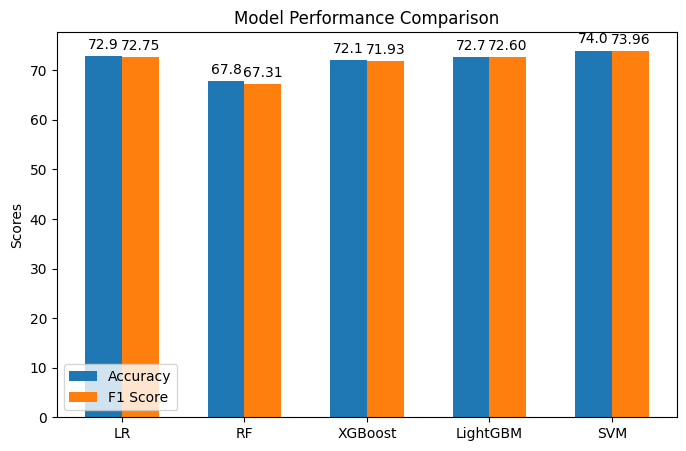

In [ ]:
models = ['LR','RF','XGBoost', 'LightGBM','SVM']
accuracy_scores = [lr_accuracy*100,rf_accuracy*100,accuracy_xgb*100, accuracy_lgbm*100, svm_accuracy*100]
f1_scores = [lr_f1*100,rf_f1*100,f1_xgb*100, f1_lgbm*100,svm_f1*100]

x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Offset above bar
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Offset above bar
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

RNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize input features
X_train_orig_n = X_train_orig / np.max(X_train_orig)
X_test_orig_n = X_test_orig / np.max(X_test_orig)

X_train_tensor = torch.tensor(X_train_orig_n, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_orig_n, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train_orig.to_numpy(), dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_orig.to_numpy(), dtype=torch.long).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 208s 203ms/step - accuracy: 0.4228 - loss: 1.0611 - val_accuracy: 0.5279 - val_loss: 0.9439
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 172s 170ms/step - accuracy: 0.5345 - loss: 0.9348 - val_accuracy: 0.5747 - val_loss: 0.8786
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 208s 206ms/step - accuracy: 0.5715 - loss: 0.8861 - val_accuracy: 0.5985 - val_loss: 0.8304
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 172s 170ms/step - accuracy: 0.5976 - loss: 0.8406 - val_accuracy: 0.6227 - val_loss: 0.8003
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 188s 186ms/step - accuracy: 0.6245 - loss: 0.7986 - val_accuracy: 0.6451 - val_loss: 0.7578
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 199s 197ms/step - accuracy: 0.6332 - loss: 0.7782 - val_accuracy: 0.6540 - val_loss: 0.7484
Epoch 7/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 175s 173ms/step - accuracy: 0.6497 - loss: 0.7533 - val_accuracy: 0.6516 - val_loss: 0.7425
Epoch 8/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 232s 230ms/step - ac

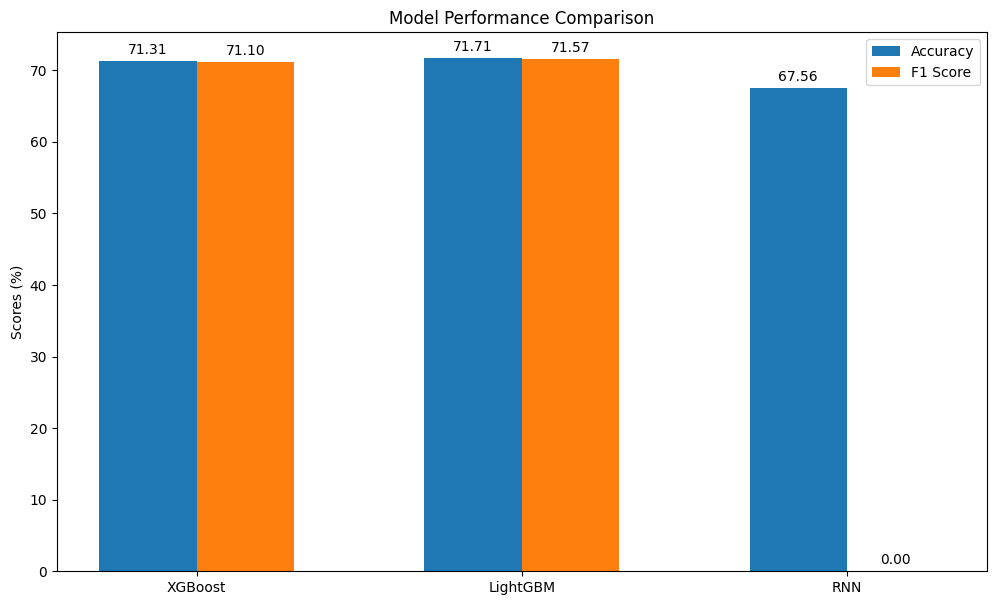

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam


input_dim = X_orig.shape[1]  # Number of features from embeddings
rnn_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(input_dim, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(3, activation='softmax')  # Assuming 3 sentiment classes
])

rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
rnn_model.fit(X_train_orig, y_train_orig, epochs=10, batch_size=64, validation_data=(X_test_orig, y_test_orig))

rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_orig, y_test_orig)



In [ ]:
print("RNN Accuracy :",rnn_accuracy*100)

RNN Accuracy : 67.56171584129333


In [ ]:


# Define PyTorch model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, output_dim=3):
        super(RNNModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(hidden_dim1 * 2, hidden_dim2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.3)
        self.lstm3 = nn.LSTM(hidden_dim2 * 2, hidden_dim3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.dropout3(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

input_dim = X_train_orig.shape[1]
print(input_dim)
model = RNNModel(input_dim).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")

# Evaluation


200
Epoch 1/10, Loss: 0.7428913161136442, Accuracy: 65.14199975250588%
Epoch 2/10, Loss: 0.654903822978023, Accuracy: 71.2814008167306%
Epoch 3/10, Loss: 0.6445030593034479, Accuracy: 71.51497339438188%
Epoch 4/10, Loss: 0.6371879810333724, Accuracy: 71.89240193045416%
Epoch 5/10, Loss: 0.6315282477358083, Accuracy: 72.06410097760178%
Epoch 6/10, Loss: 0.6282927655218145, Accuracy: 72.25900259868828%
Epoch 7/10, Loss: 0.6244316798870307, Accuracy: 72.35800024749412%
Epoch 8/10, Loss: 0.622076790265551, Accuracy: 72.42760796931073%
Epoch 9/10, Loss: 0.6171549043550402, Accuracy: 72.49412201460215%
Epoch 10/10, Loss: 0.6136644468308675, Accuracy: 72.81741121148373%


RuntimeError: input.size(-1) must be equal to input_size. Expected 200, got 1

In [ ]:
class ImprovedRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, output_dim=3):
        super(ImprovedRNNModel, self).__init__()

        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(hidden_dim1 * 2)
        self.dropout1 = nn.Dropout(0.5)

        self.lstm2 = nn.LSTM(hidden_dim1 * 2, hidden_dim2, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(hidden_dim2 * 2)
        self.dropout2 = nn.Dropout(0.5)

        self.lstm3 = nn.LSTM(hidden_dim2 * 2, hidden_dim3, batch_first=True)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.dropout3 = nn.Dropout(0.3)

        self.fc = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.transpose(1, 2)
        x = self.bn1(x)
        x = x.transpose(1, 2)
        x = self.dropout1(x)

        residual = x
        x, _ = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.bn2(x)
        x = x.transpose(1, 2)
        x = self.dropout2(x)
        x = x + residual

        x, _ = self.lstm3(x)
        x = x.transpose(1, 2)
        x = self.bn3(x)
        x = x.transpose(1, 2)
        x = self.dropout3(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

# Training setup
model = ImprovedRNNModel(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

In [ ]:



model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = 100 * correct / total
print("RNN Accuracy :", test_accuracy, "%")

NameError: name 'x_train' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_orig_n, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_orig.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_orig_n, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_orig.to_numpy(), dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class ImprovedRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=128, output_dim=3):
        super(ImprovedRNNModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=True)
        self.ln1 = nn.LayerNorm(hidden_dim1 * 2)  # Layer Normalization
        self.dropout1 = nn.Dropout(0.4)  # Increased dropout

        self.lstm2 = nn.LSTM(hidden_dim1 * 2, hidden_dim2, batch_first=True, bidirectional=True)
        self.ln2 = nn.LayerNorm(hidden_dim2 * 2)
        self.dropout2 = nn.Dropout(0.4)

        self.lstm3 = nn.LSTM(hidden_dim2 * 2, hidden_dim3, batch_first=True)
        self.ln3 = nn.LayerNorm(hidden_dim3)
        self.dropout3 = nn.Dropout(0.3)

        self.fc = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.ln1(x)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.ln2(x)
        x = self.dropout2(x)

        x, _ = self.lstm3(x)
        x = self.ln3(x)
        x = self.dropout3(x)

        x = x.squeeze(1)
        x = self.fc(x)
        return x

input_dim = X_train_orig.shape[1]
model = ImprovedRNNModel(input_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW + weight decay

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")



with open("RNN_improved.pkl","wb") as fd:
  pickle.dump(model,fd)


model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)




test_accuracy = 100 * correct / total
print("Improved RNN Accuracy:", test_accuracy, "%")


Epoch 1/50, Loss: 0.7749, Accuracy: 63.11%
Epoch 2/50, Loss: 0.6650, Accuracy: 70.44%
Epoch 3/50, Loss: 0.6524, Accuracy: 71.15%
Epoch 4/50, Loss: 0.6451, Accuracy: 71.42%
Epoch 5/50, Loss: 0.6377, Accuracy: 71.66%
Epoch 6/50, Loss: 0.6240, Accuracy: 72.38%
Epoch 7/50, Loss: 0.6202, Accuracy: 72.68%
Epoch 8/50, Loss: 0.6175, Accuracy: 72.51%
Epoch 9/50, Loss: 0.6151, Accuracy: 72.67%
Epoch 10/50, Loss: 0.6141, Accuracy: 72.67%
Epoch 11/50, Loss: 0.6065, Accuracy: 73.00%
Epoch 12/50, Loss: 0.6026, Accuracy: 73.28%
Epoch 13/50, Loss: 0.6019, Accuracy: 73.34%
Epoch 14/50, Loss: 0.6000, Accuracy: 73.30%
Epoch 15/50, Loss: 0.5984, Accuracy: 73.37%
Epoch 16/50, Loss: 0.5934, Accuracy: 73.60%
Epoch 17/50, Loss: 0.5923, Accuracy: 73.66%
Epoch 18/50, Loss: 0.5908, Accuracy: 73.78%
Epoch 19/50, Loss: 0.5904, Accuracy: 73.82%
Epoch 20/50, Loss: 0.5890, Accuracy: 73.72%
Epoch 21/50, Loss: 0.5866, Accuracy: 73.94%
Epoch 22/50, Loss: 0.5864, Accuracy: 73.84%
Epoch 23/50, Loss: 0.5851, Accuracy: 73.8

BERT

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle

# Train-Test Split (80-10-10)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df1['review'].tolist(), df1['rating'].tolist(), test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize Data
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=256)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create Datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Load Model (3 output classes)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model.to(device)

# Dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop with Progress Bar
scaler = torch.cuda.amp.GradScaler()  # Mixed precision
epochs = 3

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=True, unit="batch")

#     for batch in progress_bar:
#         optimizer.zero_grad()
#         batch = {k: v.to(device) for k, v in batch.items()}

#         with torch.cuda.amp.autocast():
#             outputs = model(**batch)
#             loss = outputs.loss

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#         lr_scheduler.step()

#         total_loss += loss.item()
#         progress_bar.set_postfix(loss=loss.item())  # Update tqdm status

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch + 1} completed! Avg Loss: {avg_loss:.4f}")



with open("BERT.pkl","rb") as fd:
  model = pickle.load(fd)

# Evaluation Function with Progress Bar
def evaluate(loader, name):
    model.eval()
    preds, true_labels = [], []
    progress_bar = tqdm(loader, desc=f"Evaluating {name}", leave=True, unit="batch")

    with torch.no_grad():
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    print(f"{name} Accuracy: {accuracy:.4f}")
    report = classification_report(true_labels, preds, target_names=["Negative", "Neutral","Positive"])
    print(f"{name} Classification Report: {report}")
    return accuracy

# Compute Accuracy with tqdm Status
test_acc = evaluate(train_loader, "Train")
val_acc = evaluate(val_loader, "Validation")
test_acc = evaluate(test_loader, "Test")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-25-251d00e47083>:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision
Evaluating Train: 100%|██████████| 506/506 [14:37<00:00,  1.73s/batch]


Train Accuracy: 0.8414
Train Classification Report:               precision    recall  f1-score   support

    Negative       0.84      0.83      0.84     21622
     Neutral       0.76      0.79      0.77     21429
    Positive       0.93      0.90      0.92     21597

    accuracy                           0.84     64648
   macro avg       0.84      0.84      0.84     64648
weighted avg       0.84      0.84      0.84     64648



Evaluating Validation: 100%|██████████| 64/64 [01:49<00:00,  1.71s/batch]


Validation Accuracy: 0.8412
Validation Classification Report:               precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      2658
     Neutral       0.78      0.78      0.78      2803
    Positive       0.91      0.91      0.91      2620

    accuracy                           0.84      8081
   macro avg       0.84      0.84      0.84      8081
weighted avg       0.84      0.84      0.84      8081



Evaluating Test: 100%|██████████| 64/64 [01:49<00:00,  1.71s/batch]

Test Accuracy: 0.8453
Test Classification Report:               precision    recall  f1-score   support

    Negative       0.84      0.85      0.85      2657
     Neutral       0.77      0.79      0.78      2705
    Positive       0.93      0.90      0.91      2720

    accuracy                           0.85      8082
   macro avg       0.85      0.85      0.85      8082
weighted avg       0.85      0.85      0.85      8082



In [ ]:

!pip uninstall jax jaxlib -y
!pip install --upgrade "jax[cpu]" -f https://storage.googleapis.com/jax-releases/jax_releases.html


Found existing installation: jax 0.4.33
Uninstalling jax-0.4.33:
  Successfully uninstalled jax-0.4.33
Found existing installation: jaxlib 0.4.33
Uninstalling jaxlib-0.4.33:
  Successfully uninstalled jaxlib-0.4.33
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.1 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Train-Test Split (80-10-10)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df1['review'].tolist(), df1['rating'].tolist(), test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize Data
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=256)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create Datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Load Model (3 output classes)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop with Progress Bar
scaler = torch.cuda.amp.GradScaler()  # Mixed precision
epochs = 6

for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=True, unit="batch")

    for batch in progress_bar:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.cuda.amp.autocast():
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())  # Update tqdm status

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed! Avg Loss: {avg_loss:.4f}")



# Evaluation Function with Progress Bar
def evaluate(loader, name):
    model.eval()
    preds, true_labels = [], []
    progress_bar = tqdm(loader, desc=f"Evaluating {name}", leave=True, unit="batch")

    with torch.no_grad():
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    print(f"{name} Accuracy: {accuracy:.4f}")
    return accuracy

# Compute Accuracy with tqdm Status
val_acc = evaluate(val_loader, "Validation")
test_acc = evaluate(test_loader, "Test")


KeyboardInterrupt: 

RoBERTa

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Train-Test Split (80-10-10)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df1['review'].tolist(), df1['rating'].tolist(), test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize Data
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=256)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create Datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Load Model (3 output classes)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

scaler = torch.cuda.amp.GradScaler()
epochs = 3

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=True, unit="batch")

#     for batch in progress_bar:
#         optimizer.zero_grad()
#         batch = {k: v.to(device) for k, v in batch.items()}

#         with torch.cuda.amp.autocast():
#             outputs = model(**batch)
#             loss = outputs.loss

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#         lr_scheduler.step()

#         total_loss += loss.item()
#         progress_bar.set_postfix(loss=loss.item())  # Update tqdm status

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch + 1} completed! Avg Loss: {avg_loss:.4f}")





with open("RoBERTa.pkl","rb") as fd:
  model = pickle.load(fd)

def evaluate(loader, name):
    model.eval()
    preds, true_labels = [], []
    progress_bar = tqdm(loader, desc=f"Evaluating {name}", leave=True, unit="batch")

    with torch.no_grad():
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    print(f"{name} Accuracy: {accuracy:.4f}")
    report = classification_report(true_labels, preds, target_names=["Negative", "Neutral","Positive"])
    print(f"{name} Classification Report: {report}")
    return accuracy

train_acc = evaluate(train_loader, "Train")
val_acc = evaluate(val_loader, "Validation")
test_acc = evaluate(test_loader, "Test")

# report = classification_report(y_test, predictions, target_names=["Negative", "Positive"])


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-2d488ecbc5d3>:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Evaluating Train: 100%|██████████| 506/506 [13:56<00:00,  1.65s/batch]


Train Accuracy: 0.8446
Train Classification Report:               precision    recall  f1-score   support

    Negative       0.85      0.83      0.84     21622
     Neutral       0.77      0.78      0.77     21429
    Positive       0.92      0.92      0.92     21597

    accuracy                           0.84     64648
   macro avg       0.85      0.84      0.84     64648
weighted avg       0.85      0.84      0.84     64648



Evaluating Validation: 100%|██████████| 64/64 [01:44<00:00,  1.63s/batch]


Validation Accuracy: 0.8432
Validation Classification Report:               precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      2658
     Neutral       0.78      0.77      0.78      2803
    Positive       0.91      0.92      0.92      2620

    accuracy                           0.84      8081
   macro avg       0.84      0.84      0.84      8081
weighted avg       0.84      0.84      0.84      8081



Evaluating Test: 100%|██████████| 64/64 [01:44<00:00,  1.63s/batch]

Test Accuracy: 0.8451
Test Classification Report:               precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      2657
     Neutral       0.77      0.78      0.78      2705
    Positive       0.93      0.91      0.92      2720

    accuracy                           0.85      8082
   macro avg       0.85      0.84      0.85      8082
weighted avg       0.85      0.85      0.85      8082



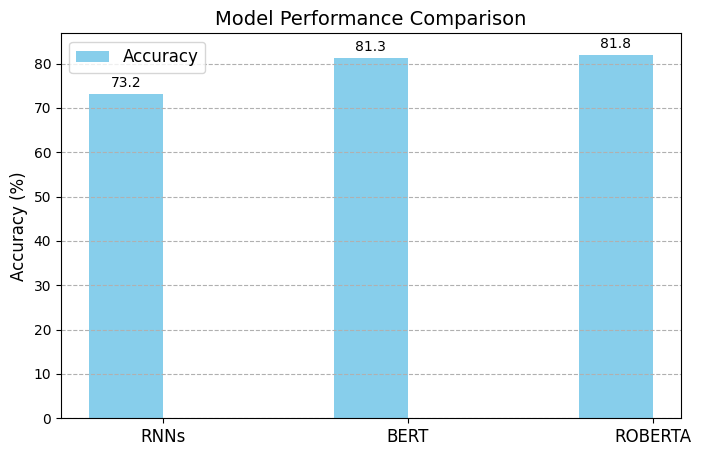

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['RNNs', 'BERT', 'ROBERTA']
accuracy_scores = [73.18, 81.30, 81.84]

x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='skyblue')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)

ax.set_ylim(0, max(accuracy_scores) + 5)
ax.grid(axis='y', linestyle='--')

for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.show()

In [ ]:
!pip install transformers datasets torch scikit-learn


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW, get_scheduler
from transformers import RobertaTokenizer, RobertaForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Train-Test Split (80-10-10)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df1['review'].tolist(), df1['rating'].tolist(), test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Tokenize Data
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=256)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create Datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Load Model (3 output classes)
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

scaler = torch.cuda.amp.GradScaler()
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=True, unit="batch")

    for batch in progress_bar:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.cuda.amp.autocast():
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())  # Update tqdm status

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed! Avg Loss: {avg_loss:.4f}")





with open("ALBERT.pkl","wb") as fd:
  pickle.dump(model,fd)

def evaluate(loader, name):
    model.eval()
    preds, true_labels = [], []
    progress_bar = tqdm(loader, desc=f"Evaluating {name}", leave=True, unit="batch")

    with torch.no_grad():
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    print(f"{name} Accuracy: {accuracy:.4f}")
    return accuracy

val_acc = evaluate(val_loader, "Validation")
test_acc = evaluate(test_loader, "Test")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch i

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 246.12 MiB is free. Process 630637 has 14.50 GiB memory in use. Of the allocated memory 14.32 GiB is allocated by PyTorch, and 49.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)